## Load trained model

In [1]:
import seq2seq
import torch
import torchtext
from seq2seq.util.checkpoint import Checkpoint
from seq2seq.loss import NLLLoss
from seq2seq.dataset import SourceField, TargetField
from seq2seq.util.string_preprocess import get_set_num, pad_tensor, stoi


In [2]:
best_model ='../supervised/bidirectional_model/best_model/'
checkpoint = Checkpoint.get_latest_checkpoint(best_model)
checkpoint = Checkpoint.load(checkpoint)
input_vocab = checkpoint.input_vocab
output_vocab = checkpoint.output_vocab
device = torch.device('cuda:0') if torch.cuda.is_available() else -1

In [3]:
model = checkpoint.model
optimizer = checkpoint.optimizer
weight = torch.ones(len(output_vocab))
pad = output_vocab.stoi['<pad>']
loss = NLLLoss(weight, pad)

/home/jaemanson/project/set2regex/venv/lib64/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
model

Seq2seq(
  (encoder): EncoderRNN(
    (input_dropout): Dropout(p=0.25, inplace=False)
    (embedding): Embedding(6, 128)
    (rnn1): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
    (rnn2): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (input_dropout): Dropout(p=0.25, inplace=False)
    (rnn): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2)
    (embedding): Embedding(14, 256)
    (attention): Attention(
      (linear_out): Linear(in_features=512, out_features=256, bias=True)
    )
    (out): Linear(in_features=256, out_features=14, bias=True)
  )
)

## Dataset load

In [5]:
train_file = '../data/_/total/max_set20/set2regex/train.txt'
set_num = get_set_num(train_file)
src = SourceField()
tgt = TargetField()

train_data = torchtext.data.TabularDataset(
    path=train_file, format='tsv',
    fields= [('src{}'.format(i+1), src) for i in range(set_num)]
    +[('tgt', tgt)]
)

src.build_vocab(train_data, max_size=500)
tgt.build_vocab(train_data, max_size=500)
input_vocab = src.vocab
output_vocab = tgt.vocab

## Visualization attention

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.switch_backend('agg')
plt.rcParams["figure.figsize"] = (11,10)
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels(['predict_regex'] + output_words.split(' '))
    ax.set_yticklabels(['examples'] + input_sentence.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


In [8]:
def evaluateRandomChoice(train_data, input_vocab, output_vocab):
    import random
    pair_data = random.choice(train_data)
    input_tensor = []
    input_len = []
    max_length = -1
    
    for num in range(1, set_num+1):
        src_string = getattr(pair_data, 'src{}'.format(num))
        if max_length < len(src_string):
            max_length = len(src_string)
        src_tensor = stoi(src_string, input_vocab)
        input_tensor.append(torch.tensor(src_tensor))
        input_len.append(torch.Tensor([len(src_tensor)]))
    
    for idx, input_var in enumerate(input_tensor):
        input_tensor[idx] = pad_tensor(input_var, max_length, input_vocab)
    
    target_string = getattr(pair_data, 'tgt')
    
    target_tensor = stoi(target_string, output_vocab )
    input_var = torch.stack(input_tensor, dim = 0).unsqueeze(dim=0).cuda()
    input_len = torch.stack(input_len, dim = 0).cuda()
    
    with torch.no_grad():
        softmax_list, _, other =model(input_var, input_len)  
        tgt_length = other['length'][0]
        tgt_id_seq = [other['sequence'][di][0].data[0] for di in range(tgt_length)]
        tgt_seq = [output_vocab.itos[tok] for tok in tgt_id_seq]
        generated_string = ' '.join(tgt_seq[:])
        
        print('ground_truth: ',' '.join(target_string))
        print('predict: ',generated_string)
        
        set_size= other['attention_score'][0][0].size(1)
        attn_set = [list() for _ in range(set_size)]
        
        for tgt_seq_idx in range(tgt_length):
            attn = other['attention_score'][tgt_seq_idx][0].squeeze(0)    
            for set_idx in range(set_size):
                attn_set[set_idx].append(attn[set_idx])
                
        for set_idx in range(set_size):
            attn_set[set_idx] = torch.stack(attn_set[set_idx], dim=0 )
        
        for set_idx in range(set_size):
            src_string = getattr(pair_data, 'src{}'.format(set_idx+1))
            showAttention(' '.join(src_string), generated_string, attn_set[set_idx].T.cpu().numpy())

ground_truth:  <sos> 2 * 0 2 1 0 3 0 * 2 2 0 ( 1 | 2 ) <eos>
predict:  2 * 0 2 1 0 3 0 * 2 2 0 1 <eos>


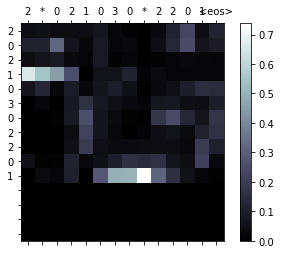

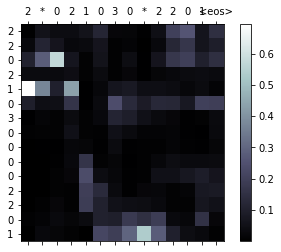

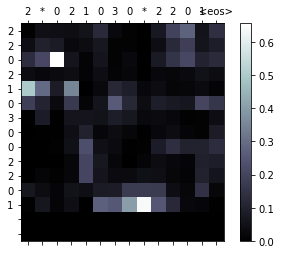

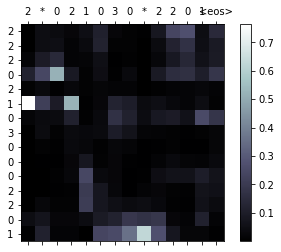

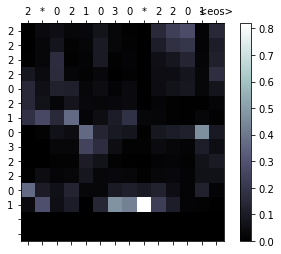

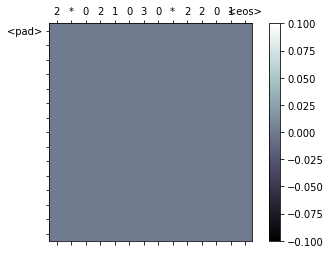

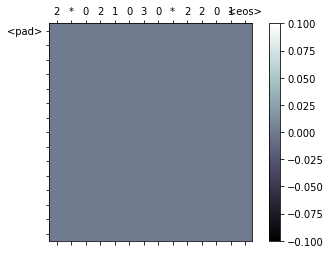

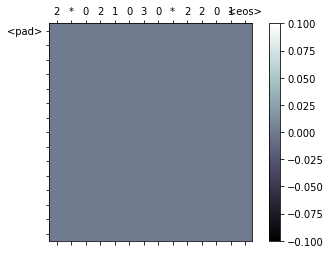

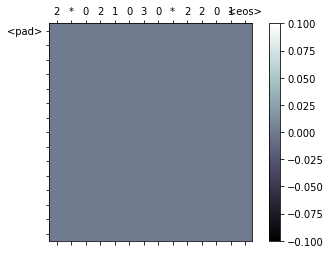

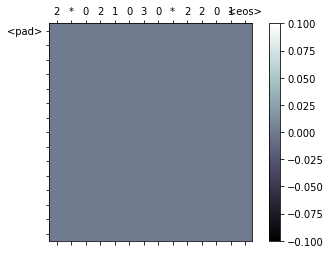

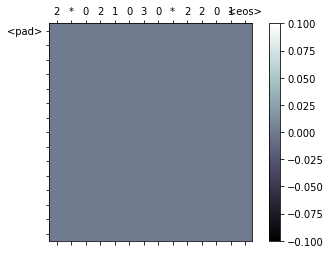

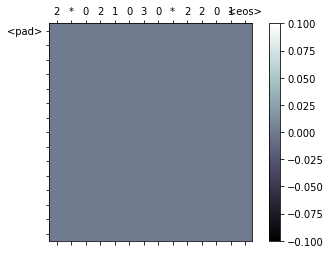

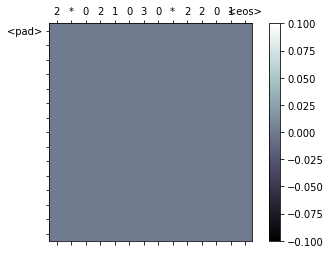

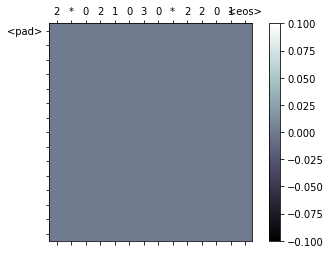

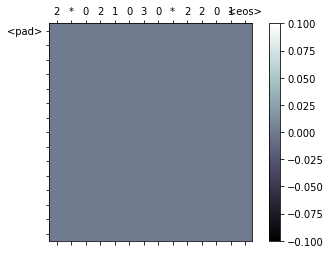

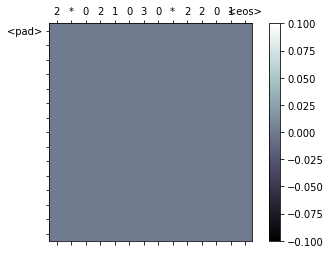

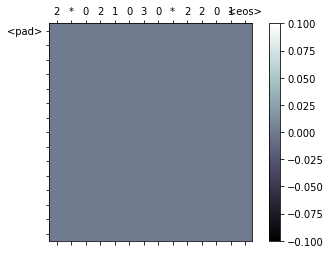

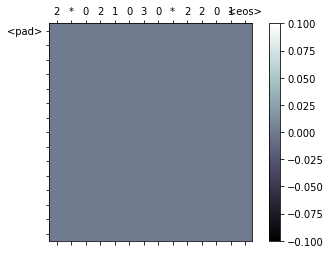

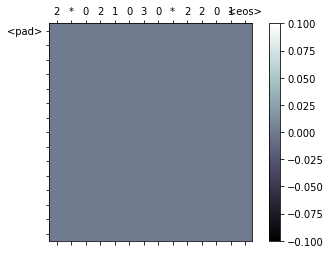

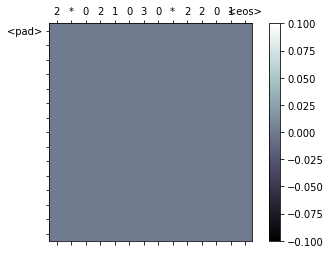

In [9]:
evaluateRandomChoice(train_data, input_vocab, output_vocab)

ground_truth:  <sos> 0 2 1 2 * 1 3 3 * ( 1 | 2 | 3 ) * 0 3 2 <eos>
predict:  0 2 1 2 * 1 3 * 3 * 1 3 0 2 3 2 <eos>


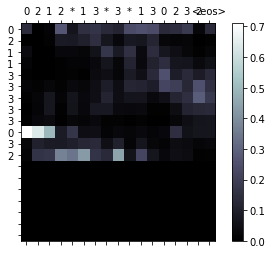

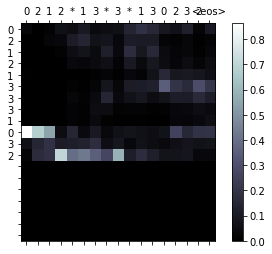

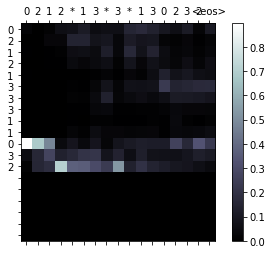

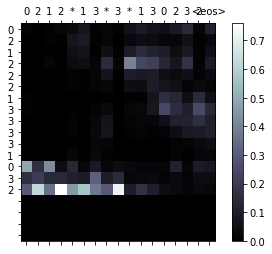

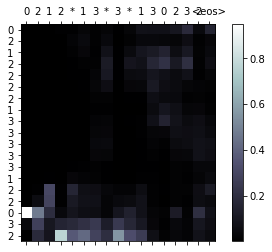

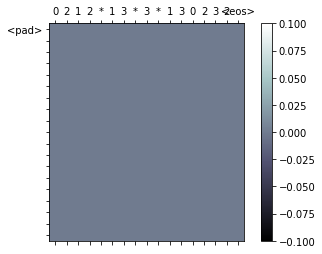

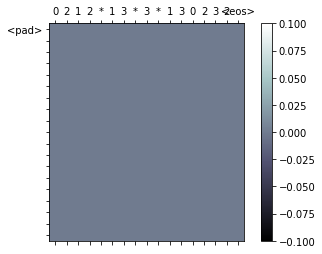

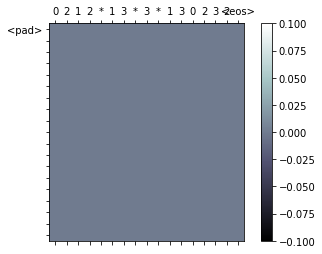

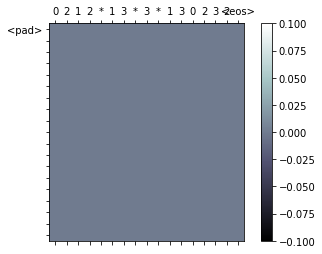

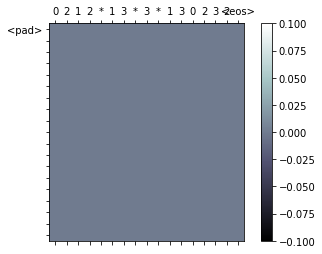

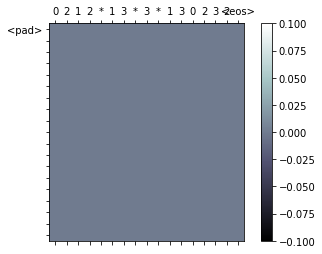

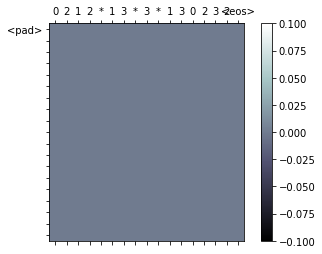

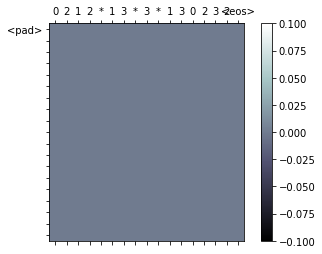

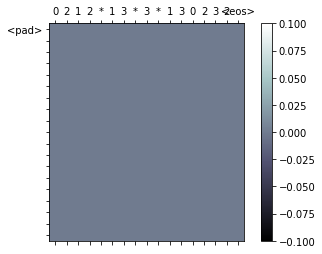

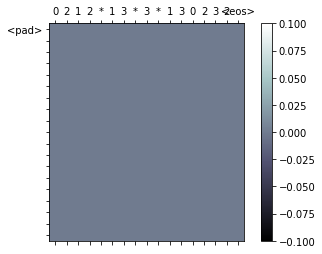

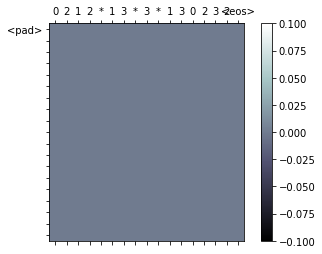

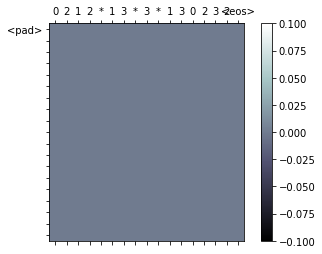

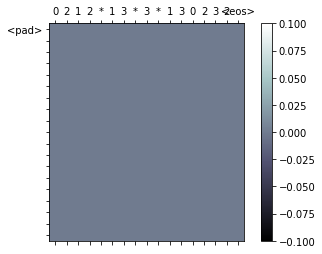

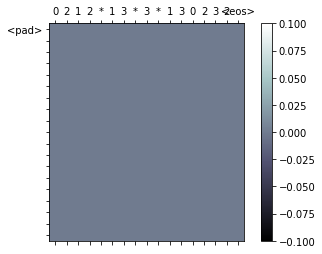

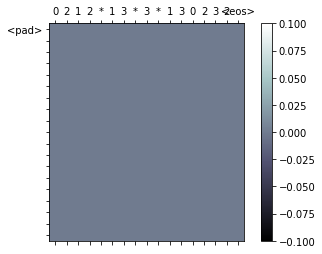

In [10]:
evaluateRandomChoice(train_data, input_vocab, output_vocab)

ground_truth:  <sos> ( 0 | 1 | 3 ) 0 3 * 3 * 0 [0-3]* <eos>
predict:  ( 0 | 1 | 3 ) 0 3 * 3 * 0 [0-3]* <eos>


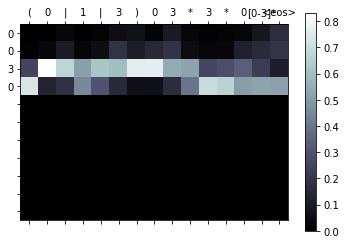

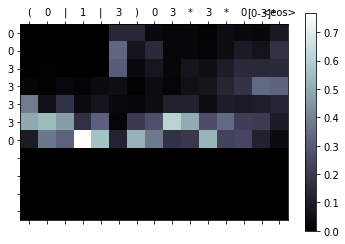

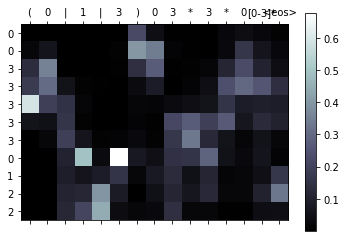

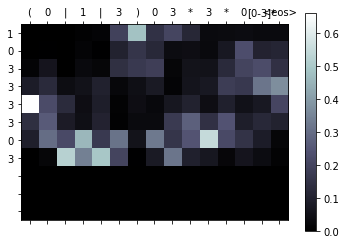

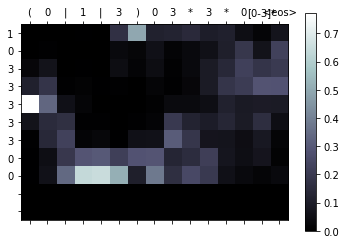

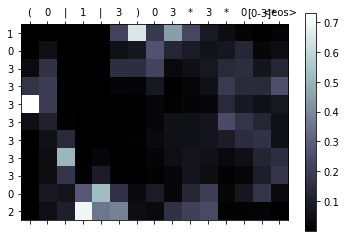

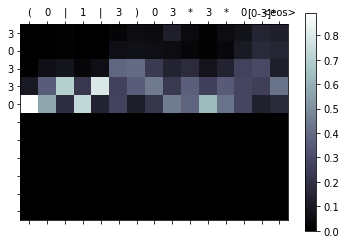

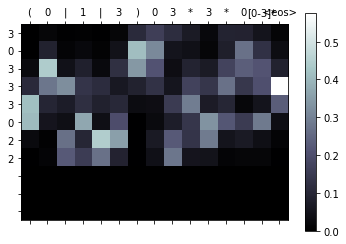

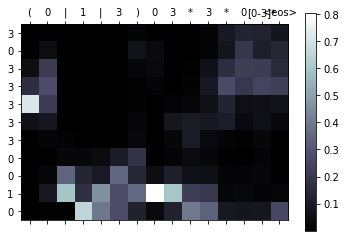

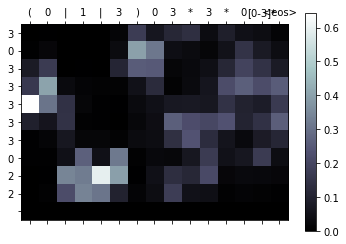

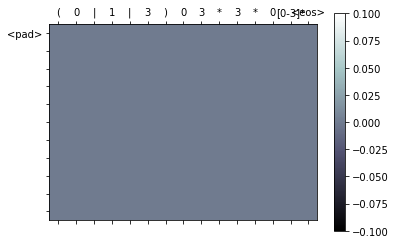

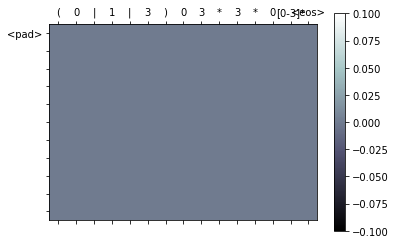

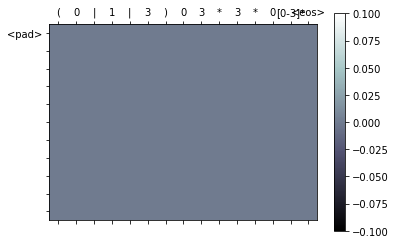

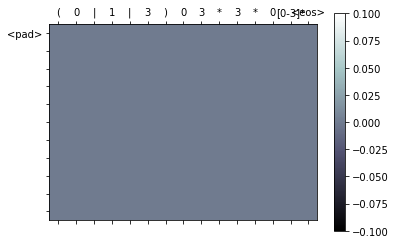

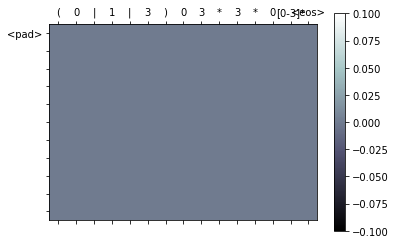

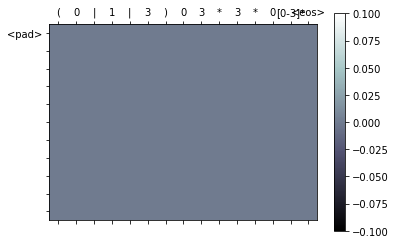

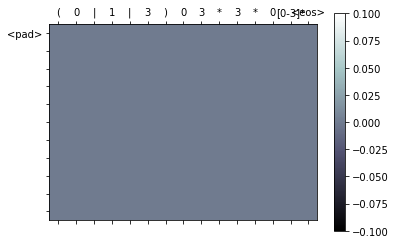

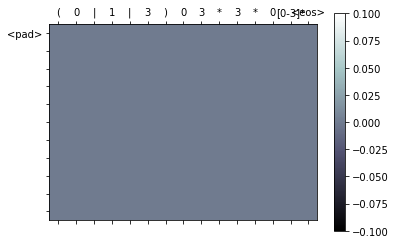

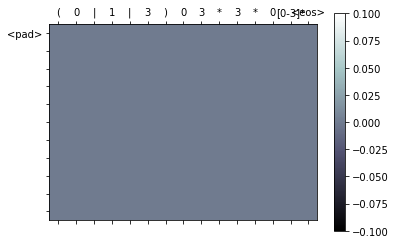

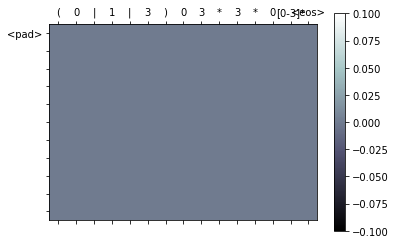

In [11]:
evaluateRandomChoice(train_data, input_vocab, output_vocab)

ground_truth:  <sos> [0-3] 2 [0-3] 2 3 2 * <eos>
predict:  [0-3] 2 ( 0 | 1 | 2 ) 2 3 2 * <eos>


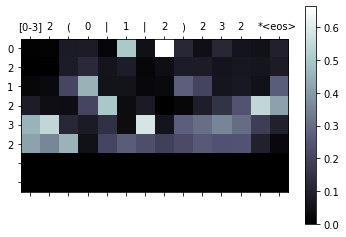

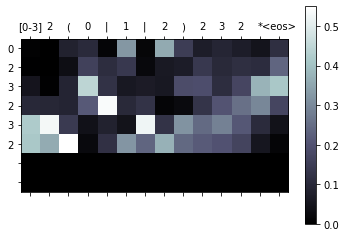

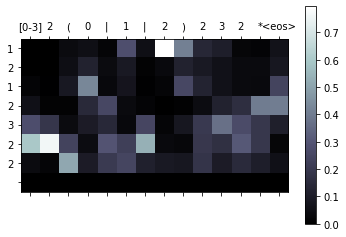

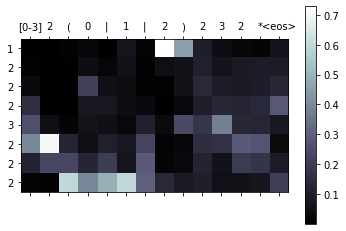

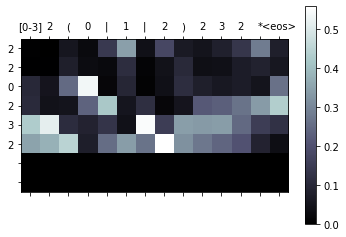

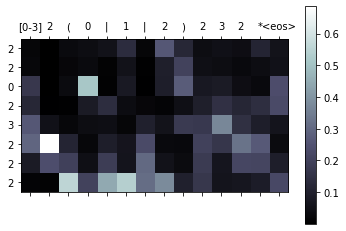

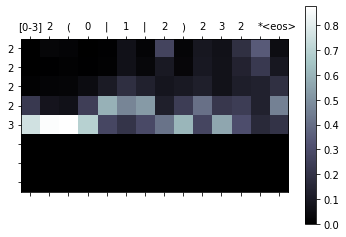

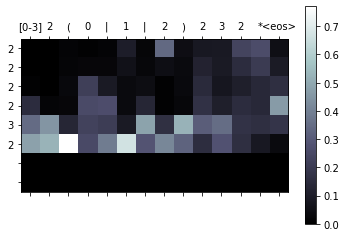

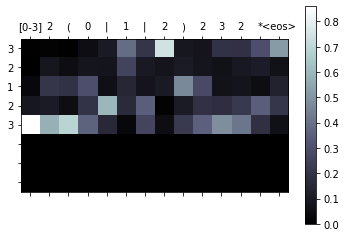

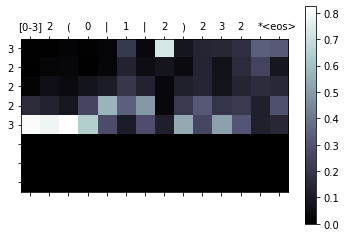

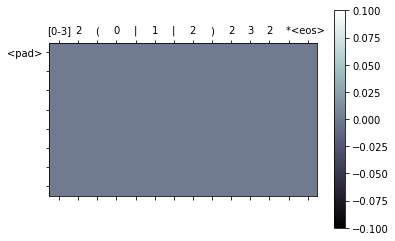

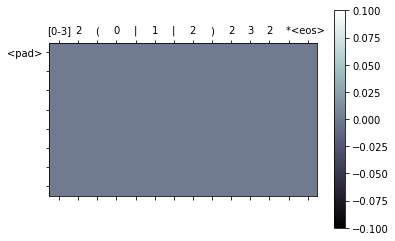

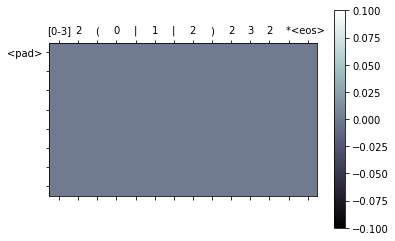

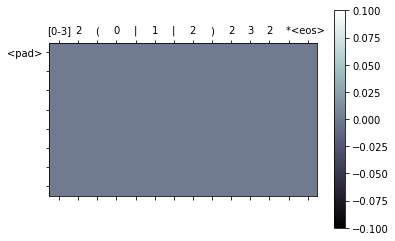

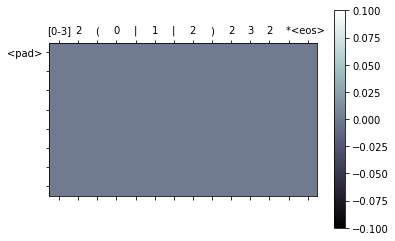

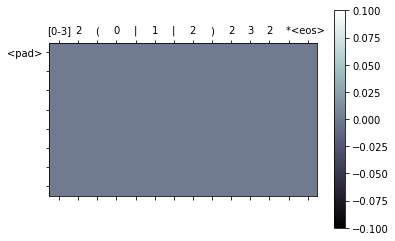

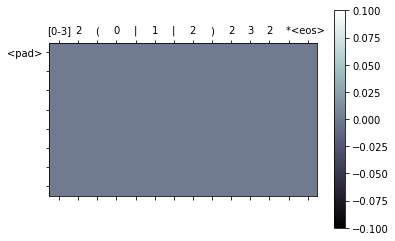

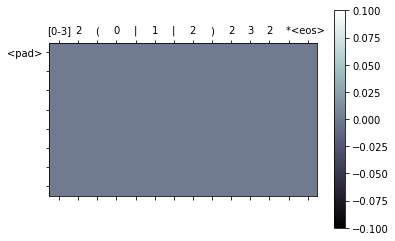

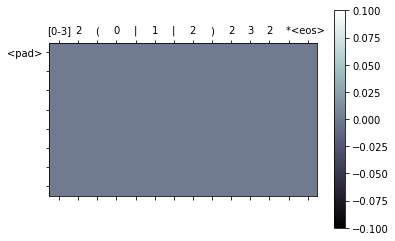

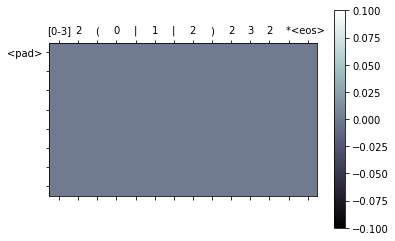

In [12]:
evaluateRandomChoice(train_data, input_vocab, output_vocab)